# Methane Problem - 2D + time

Source s(t,x) = exp(-.5(x-c)^2)

kx,ky,kz = 1
u,v,w = 1

u = wind vector
dc/dt + u*dc/dx + v * dc/dy + w * dc/dz + c(du/dx + dv/dy + dw/dz) - k_x * d2c/dx2 - k_y * d2c/dy2 - k_z * d2c/dz2 = s

In [23]:
from pde_solver import PINN
import numpy as np
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats.qmc as qmc
from scipy.stats.qmc import LatinHypercube as lhc


n = 500
# Training data
sampler = lhc(d=3)
sample = sampler.random(n=n)
dm_lb = [0,0,0]
dm_ub =[4,2,2]
lhc_pts = qmc.scale(sample,dm_lb,dm_ub)
X1 = np.transpose(lhc_pts)[0]
X2 = np.transpose(lhc_pts)[1]
X3 = np.transpose(lhc_pts)[2]


X1 = torch.tensor(X1).float()
X2 = torch.tensor(X2).float()
X3 = torch.tensor(X3).float()

icn = 20
bn = 16
X10 = torch.tensor([0] * (bn *4 + icn)).float()
X20 = torch.tensor(np.concatenate((np.linspace(0,0,bn),
                    np.linspace(2,2,bn),
                    np.linspace(0,2,bn),
                    np.linspace(0,2,bn),
                    np.random.rand(icn) * (dm_ub[1] - dm_lb[1]) + dm_lb[1] ))).float()
X30 = torch.tensor(np.concatenate((np.linspace(0,2,bn),
                    np.linspace(0,2,bn),
                    np.linspace(0,0,bn),
                    np.linspace(2,2,bn),
                    np.random.rand(icn) * (dm_ub[2] - dm_lb[2]) + dm_lb[2] 
                                        ))).float()

U0 = torch.tensor([0] * (bn * 4 + icn)).float()



# icn = 6
# bn = 3
# X10 = torch.tensor(np.concatenate((np.array([0 for _ in range(icn)]),np.linspace(0,0,4*bn) ))).float()
# X20 = torch.tensor(np.concatenate((np.random.rand(icn), np.linspace(0,1,bn), np.linspace(0,1,bn), 
#                                   np.linspace(0,0,bn), np.linspace(1,1,bn) ))).float()
# X30 = torch.tensor(np.concatenate((np.random.rand(icn), np.linspace(0,0,bn), np.linspace(1,1,bn),
#                                   np.linspace(0,1,bn), np.linspace(0,1,bn) ))).float()
# U0  = torch.pow(1 + torch.exp(a*(X20 + X30 - b*X10) + c),-1)

X1 = torch.concat([X1,X10])
X2 = torch.concat([X2,X20])
X3 = torch.concat([X3,X30])



physics_loss = {"conditions": [lambda u,x2,x3, ux1, ux2, ux3, ux2x2, ux3x3: ux1 + 1*ux2 + 1*ux3 - 1*ux2x2 - 1 * ux3x3 - (1/((2*torch.pi)**0.5) * torch.exp(-1*((x2 - (dm_lb[1]+dm_ub[1])/2)**2 + (x3 - (dm_lb[2]+dm_ub[2])/2)**2  )/2))],

                "condition_weights" : [1],
                "points" : {"x1" : X1,
                            "x2" : X2,
                            "x3" : X3},
                "point_weights" : [1 for _ in range(len(X2))]}

boundary_loss = {"points" : {"u"  : U0,
                             "x1" : X10,
                             "x2" : X20,
                             "x3" : X30},
                "point_weights" : [1000 for _ in range(len(X20))]}


model = PINN(layers=[3,100,100,100,1], physics_loss = physics_loss, boundary_loss = boundary_loss)

optimizer = optim.Adam(model.parameters(),lr=.0001)

# Create the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=6000, gamma=0.5)
scheduler = None

max_epochs = 25000
# actual = lambda x,y : (1-x**2-y**2)/4

n = 1000
# Training data
X1_test = torch.tensor(np.random.rand(n)).float()
X2_test = torch.tensor(np.random.rand(n)).float()
X3_test = torch.tensor(np.random.rand(n)).float()
status = []
for epoch in range(max_epochs+1):
            optimizer.zero_grad()
            loss_value = model.total_loss()
            loss_value.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()
            if epoch % 500 == 0:
                pl, bl = model.physics_loss().item(), model.boundary_loss().item()
                print(pl,bl)
                status.append([epoch,pl+bl])
                # mae_train_lhc = np.mean(np.abs(actual(X1.detach().numpy(),X2.detach().numpy(),X3.detach().numpy()) - 
                #                      model([X1.view(-1,1),X2.view(-1,1),X3.view(-1,1)]).detach().numpy().flatten()))
                # mae_test_lhc = np.mean(np.abs(actual(X1_test.detach().numpy(),X2_test.detach().numpy(),X3_test.detach().numpy()) - 
                #                      model([X1_test.view(-1,1), X2_test.view(-1,1), X3_test.view(-1,1)]).detach().numpy().flatten()))
                # status_lhc.append([epoch, loss_value.item(), mae_train_lhc, mae_test_lhc])
                print(f'Epoch {epoch}, Loss: {"{:e}".format(loss_value.item())}')

0.06645745784044266 9.256526947021484
Epoch 0, Loss: 1.367085e+01
0.039567045867443085 0.005367109086364508
Epoch 500, Loss: 4.504219e-02
0.00913720391690731 0.0016040658811107278
Epoch 1000, Loss: 1.077297e-02
0.0036903852596879005 0.0004328609793446958
Epoch 1500, Loss: 4.126899e-03
0.002971772337332368 0.00021094482508488
Epoch 2000, Loss: 3.183807e-03
0.0026369490660727024 0.00011772578000091016
Epoch 2500, Loss: 2.755381e-03
0.002377387136220932 6.78898359183222e-05
Epoch 3000, Loss: 2.445818e-03
0.002166059333831072 3.904247932950966e-05
Epoch 3500, Loss: 2.205522e-03
0.0019919434562325478 0.00045407016295939684
Epoch 4000, Loss: 2.207746e-03
0.0018501479644328356 1.9888670067302883e-05
Epoch 4500, Loss: 1.870411e-03
0.0017234748229384422 2.017734914261382e-05
Epoch 5000, Loss: 1.743899e-03
0.001603329903446138 2.2772204829379916e-05
Epoch 5500, Loss: 1.626483e-03
0.0014864698750898242 2.5380282750120386e-05
Epoch 6000, Loss: 1.512080e-03
0.0013738282723352313 4.204406286589801e-

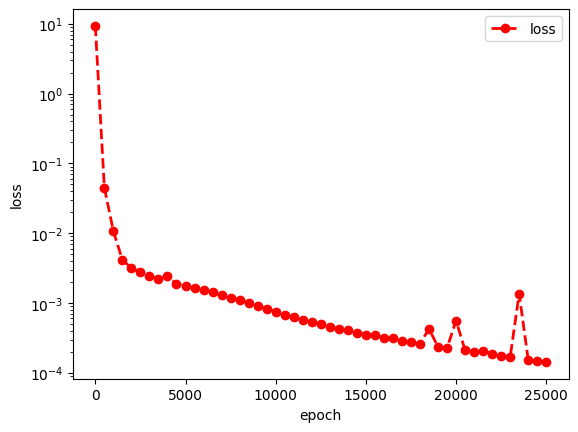

In [25]:
import pandas as pd
status_df = pd.DataFrame(columns = ['epoch','loss'], data = status)
fig,ax = plt.subplots()

ax.plot(status_df['epoch'], status_df['loss'], 'r--', linewidth=2, marker='o', label='loss')

ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

In [17]:

import matlab
import matlab.engine
# Generate data
x2 = np.linspace(0, 2, 100)
x3 = np.linspace(0, 2, 100)
x1 = np.linspace(0, 4, 100)

# Create meshgrid
X2, X3, X1 = np.meshgrid(x2, x3, x1)

# Convert to torch tensors
X2_torch = torch.tensor(X2, dtype=torch.float32)
X3_torch = torch.tensor(X3, dtype=torch.float32)
X1_torch = torch.tensor(X1, dtype=torch.float32)

# Flatten the tensors to create input for the model
X2_flat = X2_torch.view(-1, 1)
X3_flat = X3_torch.view(-1, 1)
X1_flat = X1_torch.view(-1, 1)

# Predict Z using the model and reshape to match the meshgrid
U_flat = model([X1_flat, X2_flat, X3_flat]).detach()
U = U_flat.view(X1.shape)

# Convert numpy arrays to MATLAB-compatible double arrays
X2_matlab = matlab.double(X2.tolist())
X3_matlab = matlab.double(X3.tolist())
Z_matlab = matlab.double(U.numpy().tolist())
X1_matlab = matlab.double(X1.tolist())
# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Assign variables to MATLAB workspace
eng.workspace['X2'] = X2_matlab
eng.workspace['X3'] = X3_matlab
eng.workspace['X1'] = X1_matlab
eng.workspace['U'] = Z_matlab



eng.eval("save('C:/Users/andyh/OneDrive/Documents/MATLAB');", nargout=0)
'''
# Print Z to check the values
eng.eval("disp(Z(:,:,1));", nargout=0)

# Create figure and initial plot in MATLAB
eng.eval("fig = figure;", nargout=0)
eng.eval("ax = axes('Parent', fig);", nargout=0)
eng.eval("h = surf(ax, X2(:,:,1), X3(:,:,1), Z(:,:,1));", nargout=0)
eng.eval("""
slider = uicontrol('Style', 'slider', 'Min', 1, 'Max', size(Z, 3), 'Value', 1, 'Units', 'normalized', 'Position', [0.2 0.02 0.6 0.03]);
addlistener(slider, 'ContinuousValueChange', @(src, event) updatePlot(src, event, X2, X3, Z));
""", nargout=0)

# Keep the MATLAB session running
eng.eval("uiwait(fig);", nargout=0)

# Close MATLAB engine
eng.quit()
'''

'\n# Print Z to check the values\neng.eval("disp(Z(:,:,1));", nargout=0)\n\n# Create figure and initial plot in MATLAB\neng.eval("fig = figure;", nargout=0)\neng.eval("ax = axes(\'Parent\', fig);", nargout=0)\neng.eval("h = surf(ax, X2(:,:,1), X3(:,:,1), Z(:,:,1));", nargout=0)\neng.eval("""\nslider = uicontrol(\'Style\', \'slider\', \'Min\', 1, \'Max\', size(Z, 3), \'Value\', 1, \'Units\', \'normalized\', \'Position\', [0.2 0.02 0.6 0.03]);\naddlistener(slider, \'ContinuousValueChange\', @(src, event) updatePlot(src, event, X2, X3, Z));\n""", nargout=0)\n\n# Keep the MATLAB session running\neng.eval("uiwait(fig);", nargout=0)\n\n# Close MATLAB engine\neng.quit()\n'

# Methane Problem - 3D + time

Source s(t,x) = exp(-.5(x-c)^2)

kx,ky,kz = 1
u,v,w = 1

u = wind vector
dc/dt + u*dc/dx + v * dc/dy + w * dc/dz + c(du/dx + dv/dy + dw/dz) - k_x * d2c/dx2 - k_y * d2c/dy2 - k_z * d2c/dz2 = s

In [28]:
from pde_solver import PINN
import numpy as np
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats.qmc as qmc
from scipy.stats.qmc import LatinHypercube as lhc
from itertools import product

def calculate_edges(min_vals, max_vals):
    n = len(min_vals)
    
    # Generate all vertices
    vertices = list(product(*zip(min_vals, max_vals)))
    
    edges = []
    
    # Generate edges
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            if i < j:  # Avoid duplicates
                # Check if they differ by exactly one coordinate
                diff_count = sum([1 for k in range(n) if v1[k] != v2[k]])
                if diff_count == 1:
                    edges.append((v1, v2))
    
    return edges
              
def linspace_edges(min_vals, max_vals,num):
    edges = calculate_edges(min_vals,max_vals)
    X = list()
    for i in range(len(min_vals)):
         X.append(list())
    for edge in edges:
         for i in range(len(min_vals)):
            X[i].append(np.linspace(edge[0][i],edge[1][i],num))
    for i in range(len(X)):
         X[i] = np.concatenate(X[i])
    return X
print(linspace_edges([0,0],[1,1],2))
       
n = 1000
# Training data
sampler = lhc(d=4)
sample = sampler.random(n=n)
dm_lb = [0,0,0,0]
dm_ub =[4,2,2,2]
lhc_pts = qmc.scale(sample,dm_lb,dm_ub)
X1 = np.transpose(lhc_pts)[0]
X2 = np.transpose(lhc_pts)[1]
X3 = np.transpose(lhc_pts)[2]
X4 = np.transpose(lhc_pts)[3]

le = linspace_edges(dm_lb,dm_ub,4)
X1 = torch.tensor(np.concatenate((X1,le[0]))).float()
X2 = torch.tensor(np.concatenate((X2,le[1]))).float()
X3 = torch.tensor(np.concatenate((X3,le[2]))).float()
X4 = torch.tensor(np.concatenate((X4,le[3]))).float()

icn = 30
bn = 10
le = linspace_edges(dm_lb[1:],dm_ub[1:],bn)
tbn = len(le[0])
X10 = torch.tensor([0] * (tbn + icn)).float()
X20 = torch.tensor(np.concatenate((le[0],
                    np.random.rand(icn) * (dm_ub[1] - dm_lb[1]) + dm_lb[1] ))).float()


X30 = torch.tensor(np.concatenate((le[1],
                    np.random.rand(icn) * (dm_ub[2] - dm_lb[2]) + dm_lb[2]))).float()

X40 = torch.tensor(np.concatenate((le[2],
                    np.random.rand(icn) * (dm_ub[3] - dm_lb[3]) + dm_lb[3]))).float()

U0 = torch.tensor([0] * (tbn + icn)).float()



# icn = 6
# bn = 3
# X10 = torch.tensor(np.concatenate((np.array([0 for _ in range(icn)]),np.linspace(0,0,4*bn) ))).float()
# X20 = torch.tensor(np.concatenate((np.random.rand(icn), np.linspace(0,1,bn), np.linspace(0,1,bn), 
#                                   np.linspace(0,0,bn), np.linspace(1,1,bn) ))).float()
# X30 = torch.tensor(np.concatenate((np.random.rand(icn), np.linspace(0,0,bn), np.linspace(1,1,bn),
#                                   np.linspace(0,1,bn), np.linspace(0,1,bn) ))).float()
# U0  = torch.pow(1 + torch.exp(a*(X20 + X30 - b*X10) + c),-1)

X1 = torch.concat([X1,X10])
X2 = torch.concat([X2,X20])
X3 = torch.concat([X3,X30])
X4 = torch.concat([X4,X40])




physics_loss = {"conditions": [lambda u,x2,x3,x4, ux1, ux2, ux3,ux4, ux2x2, ux3x3, ux4x4: ux1 + 1 * ux2 + 1 * ux3 + 1 * ux4 - 1 * ux2x2 - 1 * ux3x3 - 1 * ux4x4 - (1/((2*torch.pi)**0.5) * torch.exp(-1*((x2 - (dm_lb[1]+dm_ub[1])/2)**2 + (x3 - (dm_lb[2]+dm_ub[2])/2)**2 + (x4 - (dm_lb[3]+dm_ub[3])/2)**2  )/2))],

                "condition_weights" : [1],
                "points" : {"x1" : X1,
                            "x2" : X2,
                            "x3" : X3,
                            "x4" : X4},
                "point_weights" : [1 for _ in range(len(X2))]}

boundary_loss = {"points" : {"u"  : U0,
                             "x1" : X10,
                             "x2" : X20,
                             "x3" : X30,
                             "x4" : X40},
                "point_weights" : [1000 for _ in range(len(X20))]}


model = PINN(layers=[4,100,100,100,1], physics_loss = physics_loss, boundary_loss = boundary_loss)

optimizer = optim.Adam(model.parameters(),lr=.01)

# Create the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)
# scheduler = None

max_epochs = 35000
# actual = lambda x,y : (1-x**2-y**2)/4

n = 1000
# Training data
X1_test = torch.tensor(np.random.rand(n)).float()
X2_test = torch.tensor(np.random.rand(n)).float()
X3_test = torch.tensor(np.random.rand(n)).float()
status = []
for epoch in range(max_epochs+1):
            optimizer.zero_grad()
            loss_value = model.total_loss()
            loss_value.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()
            if epoch % 500 == 0:
                pl, bl = model.physics_loss().item(), model.boundary_loss().item()
                print(pl,bl)
                status.append([epoch,pl+bl])
                # mae_train_lhc = np.mean(np.abs(actual(X1.detach().numpy(),X2.detach().numpy(),X3.detach().numpy()) - 
                #                      model([X1.view(-1,1),X2.view(-1,1),X3.view(-1,1)]).detach().numpy().flatten()))
                # mae_test_lhc = np.mean(np.abs(actual(X1_test.detach().numpy(),X2_test.detach().numpy(),X3_test.detach().numpy()) - 
                #                      model([X1_test.view(-1,1), X2_test.view(-1,1), X3_test.view(-1,1)]).detach().numpy().flatten()))
                # status_lhc.append([epoch, loss_value.item(), mae_train_lhc, mae_test_lhc])
                print(f'Epoch {epoch}, Loss: {"{:e}".format(loss_value.item())}')

[array([0., 0., 0., 1., 0., 1., 1., 1.]), array([0., 1., 0., 0., 1., 1., 0., 1.])]
1.0239297151565552 2570.808837890625
Epoch 0, Loss: 1.294808e+01
0.005201263353228569 0.004781386815011501
Epoch 500, Loss: 1.001849e-02
0.0023016773629933596 0.0007056649774312973
Epoch 1000, Loss: 3.011131e-03
0.0019237499218434095 0.00017132538778241724
Epoch 1500, Loss: 2.095958e-03
0.0016841000178828835 9.14108895813115e-05
Epoch 2000, Loss: 1.776013e-03
0.0014509727479889989 7.62245399528183e-05
Epoch 2500, Loss: 1.527670e-03
0.001216382603161037 7.473906589439139e-05
Epoch 3000, Loss: 1.291364e-03
0.0010856755543500185 7.588563312310725e-05
Epoch 3500, Loss: 1.161837e-03
0.0009409026242792606 7.777856080792844e-05
Epoch 4000, Loss: 1.018973e-03
0.0007952621672302485 7.877774623921141e-05
Epoch 4500, Loss: 8.743253e-04
0.0006863537128083408 7.633210043422878e-05
Epoch 5000, Loss: 7.629669e-04
0.0006011087098158896 7.463691144948825e-05
Epoch 5500, Loss: 6.760394e-04
0.0005474344943650067 7.23572302

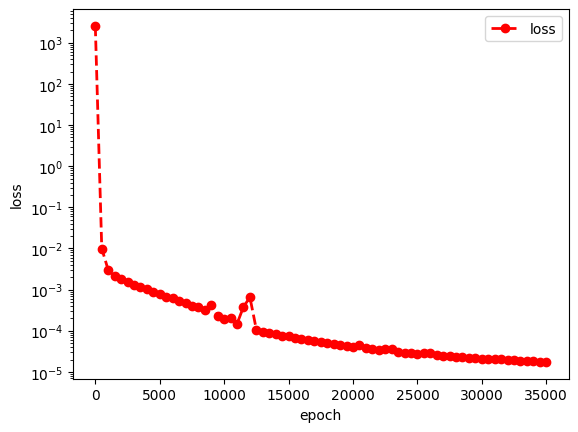

In [29]:
import pandas as pd
status_df = pd.DataFrame(columns = ['epoch','loss'], data = status)
fig,ax = plt.subplots()

ax.plot(status_df['epoch'], status_df['loss'], 'r--', linewidth=2, marker='o', label='loss')

ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

In [30]:

import matlab
import matlab.engine
# Generate data
x4 = np.linspace(0, 2, 20)
x2 = np.linspace(0, 2, 40)
x3 = np.linspace(0, 2, 40)
x1 = np.linspace(0, 4, 20)

# Create meshgrid
X2, X3, X4, X1 = np.meshgrid(x2, x3,x4, x1)

# Convert to torch tensors
X2_torch = torch.tensor(X2, dtype=torch.float32)
X3_torch = torch.tensor(X3, dtype=torch.float32)
X1_torch = torch.tensor(X1, dtype=torch.float32)
X4_torch = torch.tensor(X4, dtype=torch.float32)

# Flatten the tensors to create input for the model
X2_flat = X2_torch.view(-1, 1)
X3_flat = X3_torch.view(-1, 1)
X1_flat = X1_torch.view(-1, 1)
X4_flat = X4_torch.view(-1, 1)

# Predict Z using the model and reshape to match the meshgrid
U_flat = model([X1_flat, X2_flat, X3_flat,X4_flat]).detach()
U = U_flat.view(X1.shape)

# Convert numpy arrays to MATLAB-compatible double arrays
X2_matlab = matlab.double(X2.tolist())
X3_matlab = matlab.double(X3.tolist())
Z_matlab = matlab.double(U.numpy().tolist())
X1_matlab = matlab.double(X1.tolist())
X4_matlab = matlab.double(X4.tolist())
# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Assign variables to MATLAB workspace
eng.workspace['X2'] = X2_matlab
eng.workspace['X3'] = X3_matlab
eng.workspace['X1'] = X1_matlab
eng.workspace['U'] = Z_matlab
eng.workspace['X4'] = X4_matlab



eng.eval("save('C:/Users/andyh/OneDrive/Documents/MATLAB');", nargout=0)
'''
# Print Z to check the values
eng.eval("disp(Z(:,:,1));", nargout=0)

# Create figure and initial plot in MATLAB
eng.eval("fig = figure;", nargout=0)
eng.eval("ax = axes('Parent', fig);", nargout=0)
eng.eval("h = surf(ax, X2(:,:,1), X3(:,:,1), Z(:,:,1));", nargout=0)
eng.eval("""
slider = uicontrol('Style', 'slider', 'Min', 1, 'Max', size(Z, 3), 'Value', 1, 'Units', 'normalized', 'Position', [0.2 0.02 0.6 0.03]);
addlistener(slider, 'ContinuousValueChange', @(src, event) updatePlot(src, event, X2, X3, Z));
""", nargout=0)

# Keep the MATLAB session running
eng.eval("uiwait(fig);", nargout=0)

# Close MATLAB engine
eng.quit()
'''

'\n# Print Z to check the values\neng.eval("disp(Z(:,:,1));", nargout=0)\n\n# Create figure and initial plot in MATLAB\neng.eval("fig = figure;", nargout=0)\neng.eval("ax = axes(\'Parent\', fig);", nargout=0)\neng.eval("h = surf(ax, X2(:,:,1), X3(:,:,1), Z(:,:,1));", nargout=0)\neng.eval("""\nslider = uicontrol(\'Style\', \'slider\', \'Min\', 1, \'Max\', size(Z, 3), \'Value\', 1, \'Units\', \'normalized\', \'Position\', [0.2 0.02 0.6 0.03]);\naddlistener(slider, \'ContinuousValueChange\', @(src, event) updatePlot(src, event, X2, X3, Z));\n""", nargout=0)\n\n# Keep the MATLAB session running\neng.eval("uiwait(fig);", nargout=0)\n\n# Close MATLAB engine\neng.quit()\n'